<a href="https://colab.research.google.com/github/mldev92/mldev92/blob/main/%7C_TBPS_1_%7CYOLOv8_Stas_Bridge_IT_%D0%A3%D0%98%D0%98_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Проверка видеокарты

YOLO модели большие и долго обучаются.

Для параллелизации вычислений необходима видеокрта. Она ускоряет процесс обучения в разы.

## Установка библиотек

In [ ]:
!pip install ultralytics==8.0.227

## Импорт библиотек

In [ ]:
import os # импортируем библиотеку для взаимодействия с операционной системой
import cv2 # импортируем библиотеку для работы с изображениями
import random # импортируем библиотеку для генерации рандомных данных
import numpy as np # импортируем библиотеку линейной алгебры
import matplotlib.pyplot as plt # импортируем библиотеку для визуализации данных

from PIL import Image # импортируем модуль для работы с изображениями
from zipfile import ZipFile # импортируем класс для работы с zip архивами
from ultralytics import YOLO # импортируем класс модели
from ultralytics.engine.results import Results # импортируем класс результата, возвращаемого в списке после предикта

from typing import Sequence, Generator, Literal, TypeAlias # импортируем дополнительные типы для лучшей читаемости кода

In [ ]:
# Определение констант
BASE_DIR = "dataset"
RES_DIR = "runs/detect/train"
# ANNOTATIONS_PATH = "dataset/annotation/annotation/YOLO-format"
IMAGES_PATH = "dataset/images/images"

DATASET_DIR = "dataset/data"
ANNOTATIONS_PATH = f"{DATASET_DIR}/labels"

DATASET_LABELS_DIR  = f"{DATASET_DIR}/labels"
DATASET_IMAGES_DIR  = f"{DATASET_DIR}/images"
DATASET_CONFIG_PATH = f"{DATASET_DIR}/dataset.yaml"

VAL_SIZE = 0.2
TEST_SIZE = 0.1

ExtractedResults: TypeAlias = dict[str, tuple[list, np.ndarray]]

## Создание вспомогательных функций для отображения фото

In [ ]:
# функция для загрузки изображения
def get_image(filename: str, dir: str = IMAGES_PATH) -> np.ndarray:
  """
Загрузка изображения в массив numpy по пути.

filename: имя файла
dir: каталог с файлом
returns: изображение в виде массива numpy.ndarray
raises: None
"""
  return cv2.imread(f"{dir}/{filename}")

In [ ]:
# функция для загрузки лейблов
def get_annotation(filename: str, dir: str = ANNOTATIONS_PATH) -> list[list[float]]:
  """
Загрузка аннотации по пути.

filename: имя файла
dir: каталог файлов
returns: список ограничивающих рамок (bounding boxes)
raises: None
"""
  with open(f"{dir}/{filename}") as file:
    text = file.read() # читаем содержимое файла

  boxes = text.split("\n") # получаем список с отдельными bounding box-ами деля строку по символу переноса
  if "" in boxes: boxes.remove("") # удаляем пробел если он сушествет
  return [list(map(float, box.split())) for box in boxes] # для каждого элемента преобразовываем строку в список с числами с плавающей точкой

In [ ]:
# функция для извлечения точек из данных о bounding box и изменения их значений под размер конкретного изображения
def make_points(image_w: int, image_h: int, box: list[float]) -> tuple[tuple[int, int], tuple[int, int]]:
  """
Извлечение двух точек из ограничительной рамки и масштабирование их для определенного размера изображения.

image_w: ширина изображения
image_h: высота изображения
box: ограничивающий прямоугольник
returns: кортеж с двумя точками
raises: None
"""
  w_offset = box[3]
  h_offset = box[4]
  points1 = (int((box[1]-w_offset/2)*image_w), int((box[2]-h_offset/2)*image_h))
  points2 = (int((box[1]+w_offset/2)*image_w), int((box[2]+w_offset/2)*image_h))
  return points1, points2

In [ ]:
# функция для отрисовки прямоугольника на изображении
def draw_boxes(image: np.ndarray, boxes: list[list[float]]) -> np.ndarray:
  """
Рисование ограничивающих рамок на изображении.

image: изображение в виде массива numpy.ndarray
box: список ограничивающих рамок
returns: изображение в виде массива numpy.ndarray
raises: None
"""
  new_image = image.copy() # копируем оригинальное изображение
  for box in boxes:
    points = make_points(*image.shape[-2::-1], box) # извлекаем точки
    cv2.rectangle(new_image, points[0], points[1], (255, 0, 0), 4) # рисуем прямоугольник
  return new_image

In [ ]:
# функция для сравнения изображений с исходными и предсказанными bounding box-ами
def compare_with_original(model_results: ExtractedResults, set_type: Literal["train", "val", "test"]) -> None:
  """
Отображение 6 изображений (3 пары рядом друг с другом) для сравнения исходного расположения ограничивающих рамок с прогнозируемым.

model_results: TypeAlias = dict[str, tuple[list, np.ndarray]]
set_type: выборка датасета, из которой нужно получить данные. Один из ["train", "val", "test"]
returns: None
raises: None
"""
  images_names = random.choices(list(model_results.keys()), k=3) # рандомно выбираем 3 имнени изображений из списка предсказанных
  fig, axes = plt.subplots(3, 2, figsize=(16, 14))                 # создаём полотна для графиков

  for i, name in enumerate(images_names):
    img = get_image(name, f"{DATASET_IMAGES_DIR}/{set_type}")                                    # извлекаем оригинал изображения
    annotation = get_annotation(f"{name.split('.')[0]}.txt", f"{DATASET_LABELS_DIR}/{set_type}") # извлекаем лейбл
    new_img = draw_boxes(img, annotation)                        # отрисовываем ограничивающие рамки
    predicted_img = model_results[name][1]                       # извлекаем готовое изображение из списка предсказанных

    axes[i][0].axis("off")
    axes[i][0].imshow(new_img)
    axes[i][1].axis("off")
    axes[i][1].imshow(predicted_img)

  axes[0][0].set_title("Original BB layout", {"fontsize": 20})
  axes[0][1].set_title("YOLO predictions",   {"fontsize": 20})
  fig.tight_layout()
  fig.show()

## Создание вспомогательных функций для работы с моделью

In [ ]:
# функция для извлечения предсказаний
def extract_predictions(predictions_generator: Generator[Results, None, None]) -> ExtractedResults:
  """
Извлечение прогнозов из генератора.

predictions_generator: генератор, дающий результаты прогнозирования
returns: TypeAlias = dict[str, tuple[list, np.ndarray]]
raises: None
"""
  results = {}
  predicted_count = 0

  for i, pred in enumerate(predictions_generator):
    img = pred.path.split("/")[-1]            # извлекаем имя файла из полного пути
    classes = pred.boxes.cls.tolist()         # извлекаем предсказанные объекты в список
    predicted_count += classes.count(0) # увеличиваем счётчик людей на количество найденных людей

    if classes: results[img] = (classes, pred.plot()) # добавляем предсказание к результатам если найден хотя бы один объект

  return results, predicted_count

## Создание структуры датасета

In [ ]:
# !pip install gdown

# import gdown

# # https://drive.google.com/file/d/1ryqw6Pl6zm9DYPecrkReYElOdOYQjadB/view?usp=drive_link

# file_id = '1ryqw6Pl6zm9DYPecrkReYElOdOYQjadB'  # Замените на фактический идентификатор файла
# destination = '/content/dataset.zip'  # Путь, куда будет сохранен загруженный файл

# gdown.download(f'https://drive.google.com/uc?id={file_id}', destination, quiet=False)

In [ ]:
# !rm -r /content/dataset_old

In [ ]:
# Скачивание датасета в dataset.zip
# !wget https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/Vv9odXoQdBy0Zg -O dataset.zip

In [ ]:
# Извлечение датасета в директорию {BASE_DIR}
with ZipFile("dataset.zip", "r") as zip_file:
   zip_file.extractall(BASE_DIR)

In [ ]:
# Создание списков с названиями файлов
annotations = sorted(os.listdir(ANNOTATIONS_PATH), key=lambda x: str(x.split(".")[0])) # извлечение сортированного по имени списка имён лейблов
images = sorted(os.listdir(IMAGES_PATH), key=lambda x: str(x.split(".")[0])) # извлечение сортированного по имени списка имён изображений

assert len(annotations) == len(images) # проверка совпадения длин обоих списков
assert [name.split(".")[0] for name in annotations] == [name.split(".")[0] for name in images] # проверка соответствия имён изображений и лейблов

При обучении YOLOv8 мы должны описать структуру датасета в `.yaml` файле конфигурации.

Путь до этого файла будет передаваться в функцию обучения модели.


Константы с путями до директорий изображений и лейблов уже определены.

In [ ]:
# Визуализация ранее инициализированных констант
print(f"{DATASET_DIR=}")
print(f"{DATASET_LABELS_DIR=}")
print(f"{DATASET_IMAGES_DIR=}")

DATASET_DIR='dataset/data'
DATASET_LABELS_DIR='dataset/data/labels'
DATASET_IMAGES_DIR='dataset/data/images'


#### Создадим их и субдиректории с делением на выборки.

In [ ]:
# Создание директорий под тренировочную, тестовую и валидационную выборки
# os.mkdir(DATASET_DIR)
# os.mkdir(DATASET_LABELS_DIR)
os.mkdir(DATASET_IMAGES_DIR)

os.mkdir(f"{DATASET_LABELS_DIR}/train")
os.mkdir(f"{DATASET_LABELS_DIR}/val")
os.mkdir(f"{DATASET_LABELS_DIR}/test")

os.mkdir(f"{DATASET_IMAGES_DIR}/train")
os.mkdir(f"{DATASET_IMAGES_DIR}/val")
os.mkdir(f"{DATASET_IMAGES_DIR}/test")

#### Опишем структуру в файле конфигурации.

In [ ]:
# Добавим описание структуры датасета

dataset_configuration = f"""
path: /content/{DATASET_DIR}
train: images/train
val: images/val

names:
  0: TBPS

"""

with open(DATASET_CONFIG_PATH, "w") as file:
  file.write(dataset_configuration)

print(f"Конфигурация \n\"\"\"{dataset_configuration}\"\"\" записана в {DATASET_CONFIG_PATH}")

Конфигурация 
"""
path: /content/dataset/data
train: images/train
val: images/val

names:
  0: person

""" записана в dataset/data/dataset.yaml


#### Теперь поделим данные на выборки.

In [ ]:
# Визуализация ранее инициализированных констант
print(f"{VAL_SIZE=}")
print(f"{TEST_SIZE=}")

VAL_SIZE=0.2
TEST_SIZE=0.1


In [ ]:
# Перемешивание данных перед переносом
data_filenames = list(zip(annotations, images)) # создаём список с кортежами из имён лейблов и изображений соответственно:
                                               #   [(1.txt, 1.png), (2.txt, 2.png)]
random.shuffle(data_filenames) # рандомно перемешиваем данные

In [ ]:
# Определение размера выборок
train_end_point = int(len(data_filenames) * (1 - VAL_SIZE - TEST_SIZE)) # получаем индекс конца тренировочной выборки
val_end_point = int(len(data_filenames) * (1 - TEST_SIZE)) # получаем индекс конца валидационной выборки

# Деление на выборки
TRAIN_FILENAMES = data_filenames[:train_end_point] # получаем срез с кортежами для тренировочной выборки
VAL_FILENAMES = data_filenames[train_end_point:val_end_point] # получаем срез с кортежами для валидационной выборки
TEST_FILENAMES = data_filenames[val_end_point:] # получаем срез с кортежами для тестовой выборки

#### Перенесём файлы в новые директории.

Перенести файл можно просто переименовав его вместе с путём до него.

Например переименовав файл

c

`/base/some_dir/file.txt`

на

`/base/another_dir/file.txt`

он будет просто перенесён из директории "some_dir" в директорию "another_dir"

In [ ]:
# Перенос файлов в {TRAIN_FILENAMES}
for label_filename, image_filename in TRAIN_FILENAMES:
  os.rename(f"{ANNOTATIONS_PATH}/{label_filename}", f"{DATASET_LABELS_DIR}/train/{label_filename}")
  os.rename(f"{IMAGES_PATH}/{image_filename}", f"{DATASET_IMAGES_DIR}/train/{image_filename}")

# Перенос файлов в {VAL_FILENAMES}
for label_filename, image_filename in VAL_FILENAMES:
  os.rename(f"{ANNOTATIONS_PATH}/{label_filename}", f"{DATASET_LABELS_DIR}/val/{label_filename}")
  os.rename(f"{IMAGES_PATH}/{image_filename}", f"{DATASET_IMAGES_DIR}/val/{image_filename}")

# Перенос файлов в {TEST_FILENAMES}
for label_filename, image_filename in TEST_FILENAMES:
    os.rename(f"{ANNOTATIONS_PATH}/{label_filename}", f"{DATASET_LABELS_DIR}/test/{label_filename}")
    os.rename(f"{IMAGES_PATH}/{image_filename}", f"{DATASET_IMAGES_DIR}/test/{image_filename}")

In [ ]:
# Тесты на целостность перенесённых данных

# Проверка относительного размера выборок
assert int(len(os.listdir(f"{DATASET_LABELS_DIR}/train")) / ((1 - VAL_SIZE - TEST_SIZE)*100)) == \
       int(len(os.listdir(f"{DATASET_LABELS_DIR}/val"))   / (VAL_SIZE*100)) == \
       int(len(os.listdir(f"{DATASET_LABELS_DIR}/test"))  / (TEST_SIZE*100))

# Проверка размера фотографий и лейблов каждой выборки
assert len(os.listdir(f"{DATASET_LABELS_DIR}/train")) == len(os.listdir(f"{DATASET_IMAGES_DIR}/train")) # проверка тренировочной выборки
assert len(os.listdir(f"{DATASET_LABELS_DIR}/val")) == len(os.listdir(f"{DATASET_IMAGES_DIR}/val")) # проверка валидационной выборки
assert len(os.listdir(f"{DATASET_LABELS_DIR}/test")) == len(os.listdir(f"{DATASET_IMAGES_DIR}/test")) # проверка тестовой выборки

## Проверка предобученной модели

In [ ]:
model = YOLO("yolov8m.pt")                                   # создадим инстанс модели
assert model.names[0] == "TBPS"                            # удостоверимся, что нулевым классом является человек
predictions_generator = model.predict(                       # создадим генератор предсказаний для тестовой выборки
                            f"{DATASET_IMAGES_DIR}/test",
                            stream=True,
                            verbose=False,
                            )

In [ ]:
results, predicted_count = extract_predictions(predictions_generator) # запустим процесс извлечения предсказаний из генератора

In [ ]:
# Подсчёт человек в тестовой выборке
all_bboxes = []
for annotation_filename in os.listdir(f"{DATASET_LABELS_DIR}/test"):
  all_bboxes += get_annotation(annotation_filename, f"{DATASET_LABELS_DIR}/test")

total_count = len(all_bboxes)

In [ ]:
predicted_count

1

In [ ]:
print(f"Модель нашла {int((predicted_human_count/total_human_count)*100)}% ({predicted_human_count}/{total_human_count}) человек.")

Модель нашла 0% (1/347) человек.


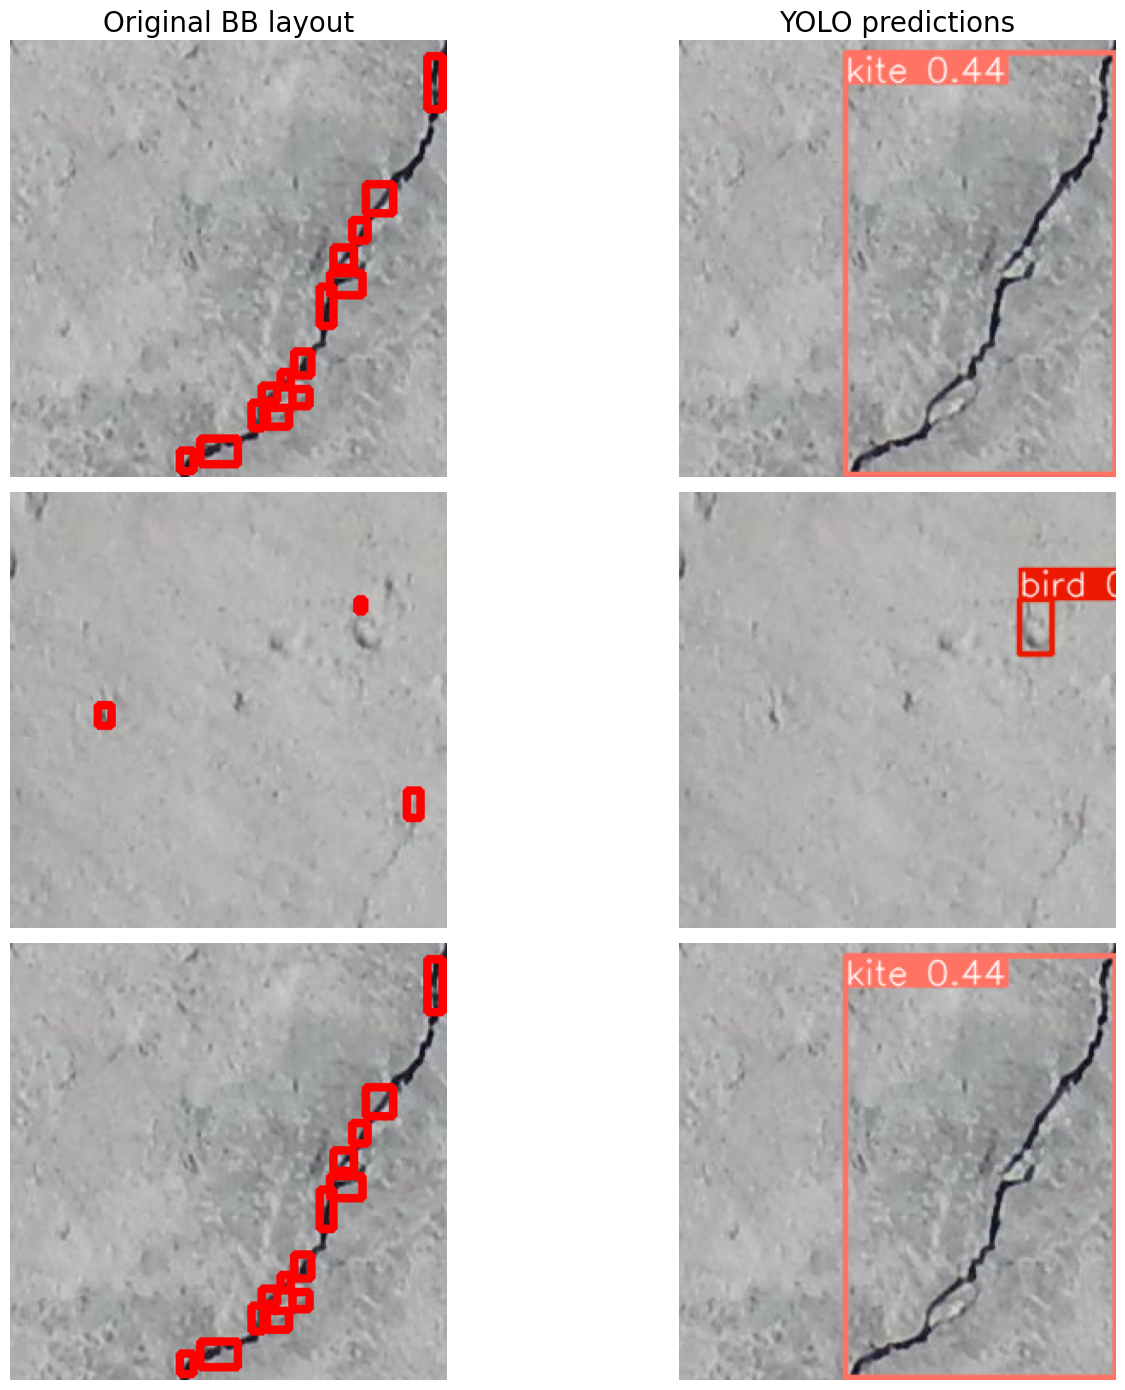

In [ ]:
# compare_with_original(results, "test")

## Обучение модели

In [ ]:
# Пересоздадим инстанс модели
model = YOLO("yolov8m.pt")

In [ ]:
res = model.train(data=DATASET_CONFIG_PATH, epochs=100)

New https://pypi.org/project/ultralytics/8.2.48 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.227 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=dataset/data/dataset.yaml, epochs=100, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, show=False, save_frames=False, save_txt=False, save_conf=Fal

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


AMP: checks passed ✅


train: Scanning /content/dataset/data/labels/train... 545 images, 16 backgrounds, 0 corrupt: 100%|██████████| 545/545 [00:00<00:00, 1986.01it/s]

train: New cache created: /content/dataset/data/labels/train.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/dataset/data/labels/val... 156 images, 1 backgrounds, 0 corrupt: 100%|██████████| 156/156 [00:00<00:00, 855.34it/s]


val: New cache created: /content/dataset/data/labels/val.cache
Plotting labels to runs/detect/train3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train3
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      7.04G      2.759      3.324      1.694        137        640:  97%|█████████▋| 34/35 [00:20<00:00,  1.92it/s]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      1/100      7.08G      2.749      3.299      1.694          2        640: 100%|██████████| 35/35 [00:21<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]

                   all        156        715    0.00794      0.442    0.00585    0.00217



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      7.33G      2.339      2.143      1.487          0        640: 100%|██████████| 35/35 [00:19<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.09it/s]

                   all        156        715    0.00088     0.0559   0.000466   0.000148



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      7.34G      2.445       2.18       1.58          1        640: 100%|██████████| 35/35 [00:17<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.12it/s]

                   all        156        715    0.00832      0.259    0.00508      0.002



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      7.37G      2.509      2.105      1.562          9        640: 100%|██████████| 35/35 [00:18<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]

                   all        156        715      0.102      0.144     0.0367     0.0101



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      7.35G       2.47      2.038      1.562         13        640: 100%|██████████| 35/35 [00:18<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]

                   all        156        715      0.212      0.361      0.186     0.0608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100       7.4G      2.421      2.085      1.578          2        640: 100%|██████████| 35/35 [00:18<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]

                   all        156        715      0.192      0.207      0.111     0.0346



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      7.36G      2.362      1.962      1.481         11        640: 100%|██████████| 35/35 [00:18<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]

                   all        156        715      0.269      0.343      0.234     0.0754



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      7.35G      2.391      1.962      1.528          5        640: 100%|██████████| 35/35 [00:18<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.98it/s]

                   all        156        715      0.229      0.217      0.142     0.0451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      7.34G      2.239      2.024      1.432          0        640: 100%|██████████| 35/35 [00:18<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.03it/s]

                   all        156        715       0.23      0.379      0.208     0.0702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      7.33G      2.319      1.951      1.464         20        640: 100%|██████████| 35/35 [00:19<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.42it/s]

                   all        156        715      0.261      0.365      0.228     0.0789



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      7.44G      2.296      1.957       1.46          2        640: 100%|██████████| 35/35 [00:18<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]

                   all        156        715      0.242      0.291      0.184     0.0592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      7.35G      2.251      1.866      1.442         15        640: 100%|██████████| 35/35 [00:18<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.56it/s]

                   all        156        715      0.312      0.315      0.256     0.0867



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      7.34G      2.278      1.886      1.477          4        640: 100%|██████████| 35/35 [00:18<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.81it/s]

                   all        156        715      0.315      0.334      0.253     0.0832



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      7.39G       2.24      1.856       1.43          2        640: 100%|██████████| 35/35 [00:18<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.62it/s]

                   all        156        715      0.287       0.29      0.206     0.0642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      7.36G      2.268      1.906      1.497          3        640: 100%|██████████| 35/35 [00:19<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.69it/s]

                   all        156        715      0.319      0.299      0.258       0.09



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      7.38G      2.211      1.878      1.421         11        640: 100%|██████████| 35/35 [00:17<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]

                   all        156        715      0.355      0.269      0.239     0.0771



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      7.35G      2.221      1.871      1.451          1        640: 100%|██████████| 35/35 [00:18<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.10it/s]

                   all        156        715      0.311      0.364      0.264     0.0928



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      7.43G      2.205       1.84      1.414          6        640: 100%|██████████| 35/35 [00:17<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.09it/s]

                   all        156        715      0.333      0.379      0.267     0.0902



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100       7.4G      2.126      1.888      1.359          0        640: 100%|██████████| 35/35 [00:18<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.52it/s]

                   all        156        715      0.336      0.373      0.287      0.104



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      7.33G      2.124      1.864      1.397          1        640: 100%|██████████| 35/35 [00:18<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.10it/s]

                   all        156        715      0.297      0.371      0.255     0.0881



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      7.35G      2.167      1.773      1.423          2        640: 100%|██████████| 35/35 [00:18<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.13it/s]

                   all        156        715      0.352      0.331      0.282      0.102



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      7.37G      2.143       1.76      1.412          5        640: 100%|██████████| 35/35 [00:18<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]

                   all        156        715      0.383      0.329        0.3      0.108



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      7.36G      2.159      1.823      1.383          7        640: 100%|██████████| 35/35 [00:18<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.55it/s]

                   all        156        715      0.308      0.227      0.183     0.0606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      7.34G      2.187      1.904      1.458          1        640: 100%|██████████| 35/35 [00:18<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.95it/s]

                   all        156        715      0.404      0.387      0.349      0.116



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      7.35G      2.124      1.774      1.364         15        640: 100%|██████████| 35/35 [00:17<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.67it/s]

                   all        156        715      0.359      0.365      0.295      0.109



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      7.39G      2.167      1.804      1.398         11        640: 100%|██████████| 35/35 [00:19<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]

                   all        156        715      0.326      0.379      0.309      0.112



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      7.35G      2.113      1.767       1.39         30        640: 100%|██████████| 35/35 [00:18<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.13it/s]

                   all        156        715      0.387      0.389      0.336      0.123



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      7.38G      2.122      1.727      1.374         14        640: 100%|██████████| 35/35 [00:17<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.75it/s]

                   all        156        715      0.355      0.375      0.319      0.117



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      7.35G       2.06      1.767      1.377          4        640: 100%|██████████| 35/35 [00:17<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.56it/s]

                   all        156        715      0.332      0.385      0.285     0.0972



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      7.39G      2.064      1.738      1.366          3        640: 100%|██████████| 35/35 [00:18<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.68it/s]

                   all        156        715      0.328      0.392      0.281     0.0968



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100       7.4G      2.048      1.716      1.375          6        640: 100%|██████████| 35/35 [00:17<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.12it/s]

                   all        156        715      0.342      0.362      0.302      0.111



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      7.41G      2.041      1.768      1.317          0        640: 100%|██████████| 35/35 [00:19<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.61it/s]

                   all        156        715      0.346      0.369      0.309      0.115



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      7.37G      2.057      1.701      1.343         15        640: 100%|██████████| 35/35 [00:18<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.11it/s]

                   all        156        715      0.402      0.384      0.348      0.127



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      7.39G       2.05      1.709       1.34          9        640: 100%|██████████| 35/35 [00:18<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.13it/s]

                   all        156        715      0.371       0.35      0.309      0.108



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      7.34G       2.01      1.822      1.313          0        640: 100%|██████████| 35/35 [00:17<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.65it/s]

                   all        156        715      0.403      0.383      0.334      0.129



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      7.37G      2.012      1.661       1.34         20        640: 100%|██████████| 35/35 [00:18<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]

                   all        156        715      0.426       0.38      0.358      0.129



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      7.35G      2.049      1.694      1.323         19        640: 100%|██████████| 35/35 [00:18<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.48it/s]

                   all        156        715      0.381      0.368       0.31      0.109



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      7.37G      2.073      1.665      1.372         10        640: 100%|██████████| 35/35 [00:18<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.70it/s]

                   all        156        715      0.399      0.387      0.352      0.129



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      7.37G      1.993      1.616      1.326          1        640: 100%|██████████| 35/35 [00:18<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.14it/s]

                   all        156        715      0.384      0.406      0.344      0.127



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      7.33G      1.956      1.607      1.327          4        640: 100%|██████████| 35/35 [00:18<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.11it/s]

                   all        156        715      0.371      0.373      0.331      0.128



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      7.38G      2.043      1.635      1.305         17        640: 100%|██████████| 35/35 [00:18<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.11it/s]

                   all        156        715      0.406      0.383      0.343      0.122



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      7.36G      2.023      1.589      1.309          3        640: 100%|██████████| 35/35 [00:18<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.52it/s]

                   all        156        715      0.397      0.406       0.36       0.14



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      7.36G      1.978      1.596      1.333          8        640: 100%|██████████| 35/35 [00:19<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.60it/s]

                   all        156        715      0.403       0.38      0.344      0.126



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      7.35G       1.97      1.711      1.303          1        640: 100%|██████████| 35/35 [00:18<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.12it/s]

                   all        156        715      0.425        0.4      0.357      0.132



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      7.36G      2.014      1.562      1.311          6        640: 100%|██████████| 35/35 [00:18<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.14it/s]

                   all        156        715      0.388      0.415      0.347      0.129



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      7.41G      1.942      1.599      1.316          5        640: 100%|██████████| 35/35 [00:18<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]

                   all        156        715       0.45       0.35      0.365      0.143



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      7.35G      1.939      1.543      1.292          8        640: 100%|██████████| 35/35 [00:19<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.09it/s]

                   all        156        715      0.406      0.408      0.365      0.136



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      7.38G      1.942      1.555      1.291          7        640: 100%|██████████| 35/35 [00:18<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.13it/s]

                   all        156        715      0.418      0.436      0.362      0.135



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      7.35G      1.965      1.542      1.324          6        640: 100%|██████████| 35/35 [00:19<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.79it/s]

                   all        156        715      0.475      0.401      0.395      0.145



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      7.34G      1.955      1.523      1.269         15        640: 100%|██████████| 35/35 [00:17<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.12it/s]

                   all        156        715      0.412      0.393      0.344      0.121



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      7.42G      1.898      1.531      1.276          1        640: 100%|██████████| 35/35 [00:19<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.46it/s]

                   all        156        715      0.401      0.392      0.349      0.124



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      7.34G      1.917      1.582      1.301          5        640: 100%|██████████| 35/35 [00:18<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.59it/s]

                   all        156        715      0.422      0.407      0.363      0.133



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      7.38G       1.88      1.551      1.292          1        640: 100%|██████████| 35/35 [00:18<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.14it/s]

                   all        156        715      0.402      0.396      0.354       0.13



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100       7.4G      1.879      1.565      1.282          1        640: 100%|██████████| 35/35 [00:18<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.09it/s]

                   all        156        715      0.385      0.393      0.348       0.13



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      7.38G      1.897      1.477      1.288          4        640: 100%|██████████| 35/35 [00:19<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.12it/s]

                   all        156        715      0.397      0.443      0.358      0.133



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      7.39G      1.851      1.497      1.258          7        640: 100%|██████████| 35/35 [00:19<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.94it/s]

                   all        156        715      0.405      0.431      0.366      0.134



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      7.33G      1.832      1.402      1.256         15        640: 100%|██████████| 35/35 [00:18<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.09it/s]

                   all        156        715      0.369      0.352      0.323       0.12



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      7.38G      1.795      1.468      1.239          0        640: 100%|██████████| 35/35 [00:18<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.74it/s]

                   all        156        715      0.404      0.383      0.345      0.127



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      7.37G      1.887      1.485      1.264         18        640: 100%|██████████| 35/35 [00:18<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.14it/s]

                   all        156        715      0.377      0.392      0.325      0.122



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      7.36G      1.846      1.411      1.256         10        640: 100%|██████████| 35/35 [00:18<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.13it/s]

                   all        156        715      0.424      0.383      0.349       0.13



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      7.32G      1.851      1.519      1.298          2        640: 100%|██████████| 35/35 [00:19<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.55it/s]

                   all        156        715      0.379      0.387      0.344      0.132



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      7.37G      1.791        1.4      1.223          0        640: 100%|██████████| 35/35 [00:18<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.09it/s]

                   all        156        715      0.393      0.421      0.367      0.134



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      7.37G      1.771      1.502      1.211          0        640: 100%|██████████| 35/35 [00:18<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.78it/s]

                   all        156        715      0.411      0.422      0.369      0.135



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      7.36G      1.816      1.407      1.261          6        640: 100%|██████████| 35/35 [00:18<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.13it/s]

                   all        156        715      0.379      0.462      0.346      0.124



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      7.35G      1.811      1.384      1.254          5        640: 100%|██████████| 35/35 [00:18<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.73it/s]

                   all        156        715      0.413       0.42      0.356      0.126



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100       7.4G      1.759      1.318      1.227          6        640: 100%|██████████| 35/35 [00:18<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.64it/s]

                   all        156        715      0.442      0.401      0.378      0.133



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      7.41G      1.748       1.31      1.215         12        640: 100%|██████████| 35/35 [00:19<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.11it/s]

                   all        156        715      0.453      0.407      0.375      0.139



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      7.37G      1.796      1.354      1.224         11        640: 100%|██████████| 35/35 [00:18<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.13it/s]

                   all        156        715      0.408      0.431      0.362      0.133



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100       7.4G       1.72      1.249      1.194          2        640: 100%|██████████| 35/35 [00:18<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.13it/s]

                   all        156        715      0.489      0.382      0.379      0.135



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      7.36G       1.74       1.29      1.221          3        640: 100%|██████████| 35/35 [00:18<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.13it/s]

                   all        156        715      0.407      0.434      0.371      0.135



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      7.37G      1.744      1.255      1.197          4        640: 100%|██████████| 35/35 [00:19<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.12it/s]

                   all        156        715      0.413      0.396      0.353      0.126



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100       7.4G      1.719      1.242      1.201          4        640: 100%|██████████| 35/35 [00:18<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.13it/s]

                   all        156        715      0.415      0.389      0.332      0.124



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      7.33G      1.735      1.287      1.209         16        640: 100%|██████████| 35/35 [00:19<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.12it/s]

                   all        156        715      0.397      0.411      0.337      0.123



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      7.35G      1.662      1.272      1.142          0        640: 100%|██████████| 35/35 [00:18<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.14it/s]

                   all        156        715      0.448      0.382      0.341      0.121



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      7.39G      1.684      1.229      1.198          4        640: 100%|██████████| 35/35 [00:18<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]

                   all        156        715      0.445      0.381      0.353      0.133



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      7.35G      1.704      1.209      1.189          9        640: 100%|██████████| 35/35 [00:19<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.69it/s]

                   all        156        715      0.436      0.378      0.347      0.121



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      7.33G      1.695      1.186      1.187          4        640: 100%|██████████| 35/35 [00:17<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.62it/s]

                   all        156        715      0.398       0.42      0.345      0.128



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      7.35G      1.657      1.185      1.205          4        640: 100%|██████████| 35/35 [00:18<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.02it/s]

                   all        156        715      0.417      0.393      0.356       0.13



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      7.42G      1.679      1.188      1.169          3        640: 100%|██████████| 35/35 [00:18<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.64it/s]

                   all        156        715      0.421      0.396      0.337      0.123



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100       7.4G      1.621      1.137      1.158          1        640: 100%|██████████| 35/35 [00:18<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]

                   all        156        715      0.439       0.41       0.35      0.125



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      7.34G       1.63      1.121      1.156          6        640: 100%|██████████| 35/35 [00:18<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]

                   all        156        715      0.375      0.404      0.325      0.118



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      7.37G       1.64      1.125      1.154          4        640: 100%|██████████| 35/35 [00:18<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.69it/s]

                   all        156        715      0.406      0.373      0.321      0.116



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      7.41G      1.602       1.14      1.152          2        640: 100%|██████████| 35/35 [00:18<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.49it/s]

                   all        156        715      0.416      0.422      0.332      0.119



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      7.39G       1.57       1.06      1.125         11        640: 100%|██████████| 35/35 [00:18<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]

                   all        156        715      0.416      0.407      0.356      0.122



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      7.39G      1.607      1.111       1.14          4        640: 100%|██████████| 35/35 [00:18<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.12it/s]

                   all        156        715      0.396      0.379      0.319      0.117



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      7.36G       1.55      1.046      1.133         13        640: 100%|██████████| 35/35 [00:18<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.14it/s]

                   all        156        715      0.423      0.386      0.342      0.123



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      7.36G      1.547      1.069      1.149          2        640: 100%|██████████| 35/35 [00:18<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.13it/s]

                   all        156        715      0.342      0.417      0.309      0.112



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      7.35G      1.588      1.086      1.135          3        640: 100%|██████████| 35/35 [00:18<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.00it/s]

                   all        156        715      0.394      0.408      0.324      0.113



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      7.35G      1.531      1.028      1.121          9        640: 100%|██████████| 35/35 [00:18<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]

                   all        156        715      0.432      0.385      0.322      0.113



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      7.36G      1.578       1.05      1.142          3        640: 100%|██████████| 35/35 [00:18<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]

                   all        156        715      0.396      0.407       0.31      0.109


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      7.36G      1.514      1.057      1.156          2        640: 100%|██████████| 35/35 [00:19<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.12it/s]

                   all        156        715      0.395      0.382      0.317       0.11



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      7.32G      1.512      1.006      1.155          4        640: 100%|██████████| 35/35 [00:17<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.74it/s]

                   all        156        715      0.385      0.397      0.307      0.111



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      7.32G      1.444      1.003      1.118          0        640: 100%|██████████| 35/35 [00:17<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]

                   all        156        715      0.386      0.401      0.314      0.115



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      7.38G      1.473     0.9865      1.157          1        640: 100%|██████████| 35/35 [00:18<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.68it/s]

                   all        156        715      0.374      0.394      0.322      0.117



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      7.34G      1.466     0.9484      1.136          4        640: 100%|██████████| 35/35 [00:18<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.69it/s]

                   all        156        715       0.42      0.396      0.342      0.122



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      7.37G      1.427     0.9196      1.114          1        640: 100%|██████████| 35/35 [00:18<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.09it/s]

                   all        156        715      0.431      0.375      0.329      0.116



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      7.37G       1.41      1.002        1.1          0        640: 100%|██████████| 35/35 [00:17<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.68it/s]

                   all        156        715      0.391      0.392      0.322      0.113



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      7.42G       1.41     0.9434      1.108          0        640: 100%|██████████| 35/35 [00:17<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.68it/s]

                   all        156        715      0.395      0.403      0.332      0.119



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      7.38G       1.41     0.9376       1.12          1        640: 100%|██████████| 35/35 [00:17<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.14it/s]

                   all        156        715      0.387      0.407      0.326      0.116
Stopping training early as no improvement observed in last 50 epochs. Best results observed at epoch 49, best model saved as best.pt.
To update EarlyStopping(patience=50) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



99 epochs completed in 0.714 hours.
Optimizer stripped from runs/detect/train3/weights/last.pt, 52.0MB
Optimizer stripped from runs/detect/train3/weights/best.pt, 52.0MB

Validating runs/detect/train3/weights/best.pt...
Ultralytics YOLOv8.0.227 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 218 layers, 25840339 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:08<00:00,  1.63s/it]


                   all        156        715      0.473      0.401      0.395      0.146
Speed: 0.4ms preprocess, 11.3ms inference, 0.0ms loss, 6.9ms postprocess per image
Results saved to runs/detect/train3


## Итоги обучения

In [ ]:
predictions_generator = model.predict(                                      # создадим генератор предсказаний для тестовой выборки
                            f"{DATASET_IMAGES_DIR}/test",
                            stream=True,
                            verbose=False,
                            )

In [ ]:
results, predicted_count = extract_predictions(predictions_generator) # запустим процесс извлечения предсказаний из генератора

print(f"Модель нашла {int((predicted_count/total_count)*100)}% ({predicted__count}/{total_count}) трещин.")

Модель нашла 63% (220/347) человек.


Отлично! Получилось увеличить точность на 63%

Посмотрим на графики обучения:

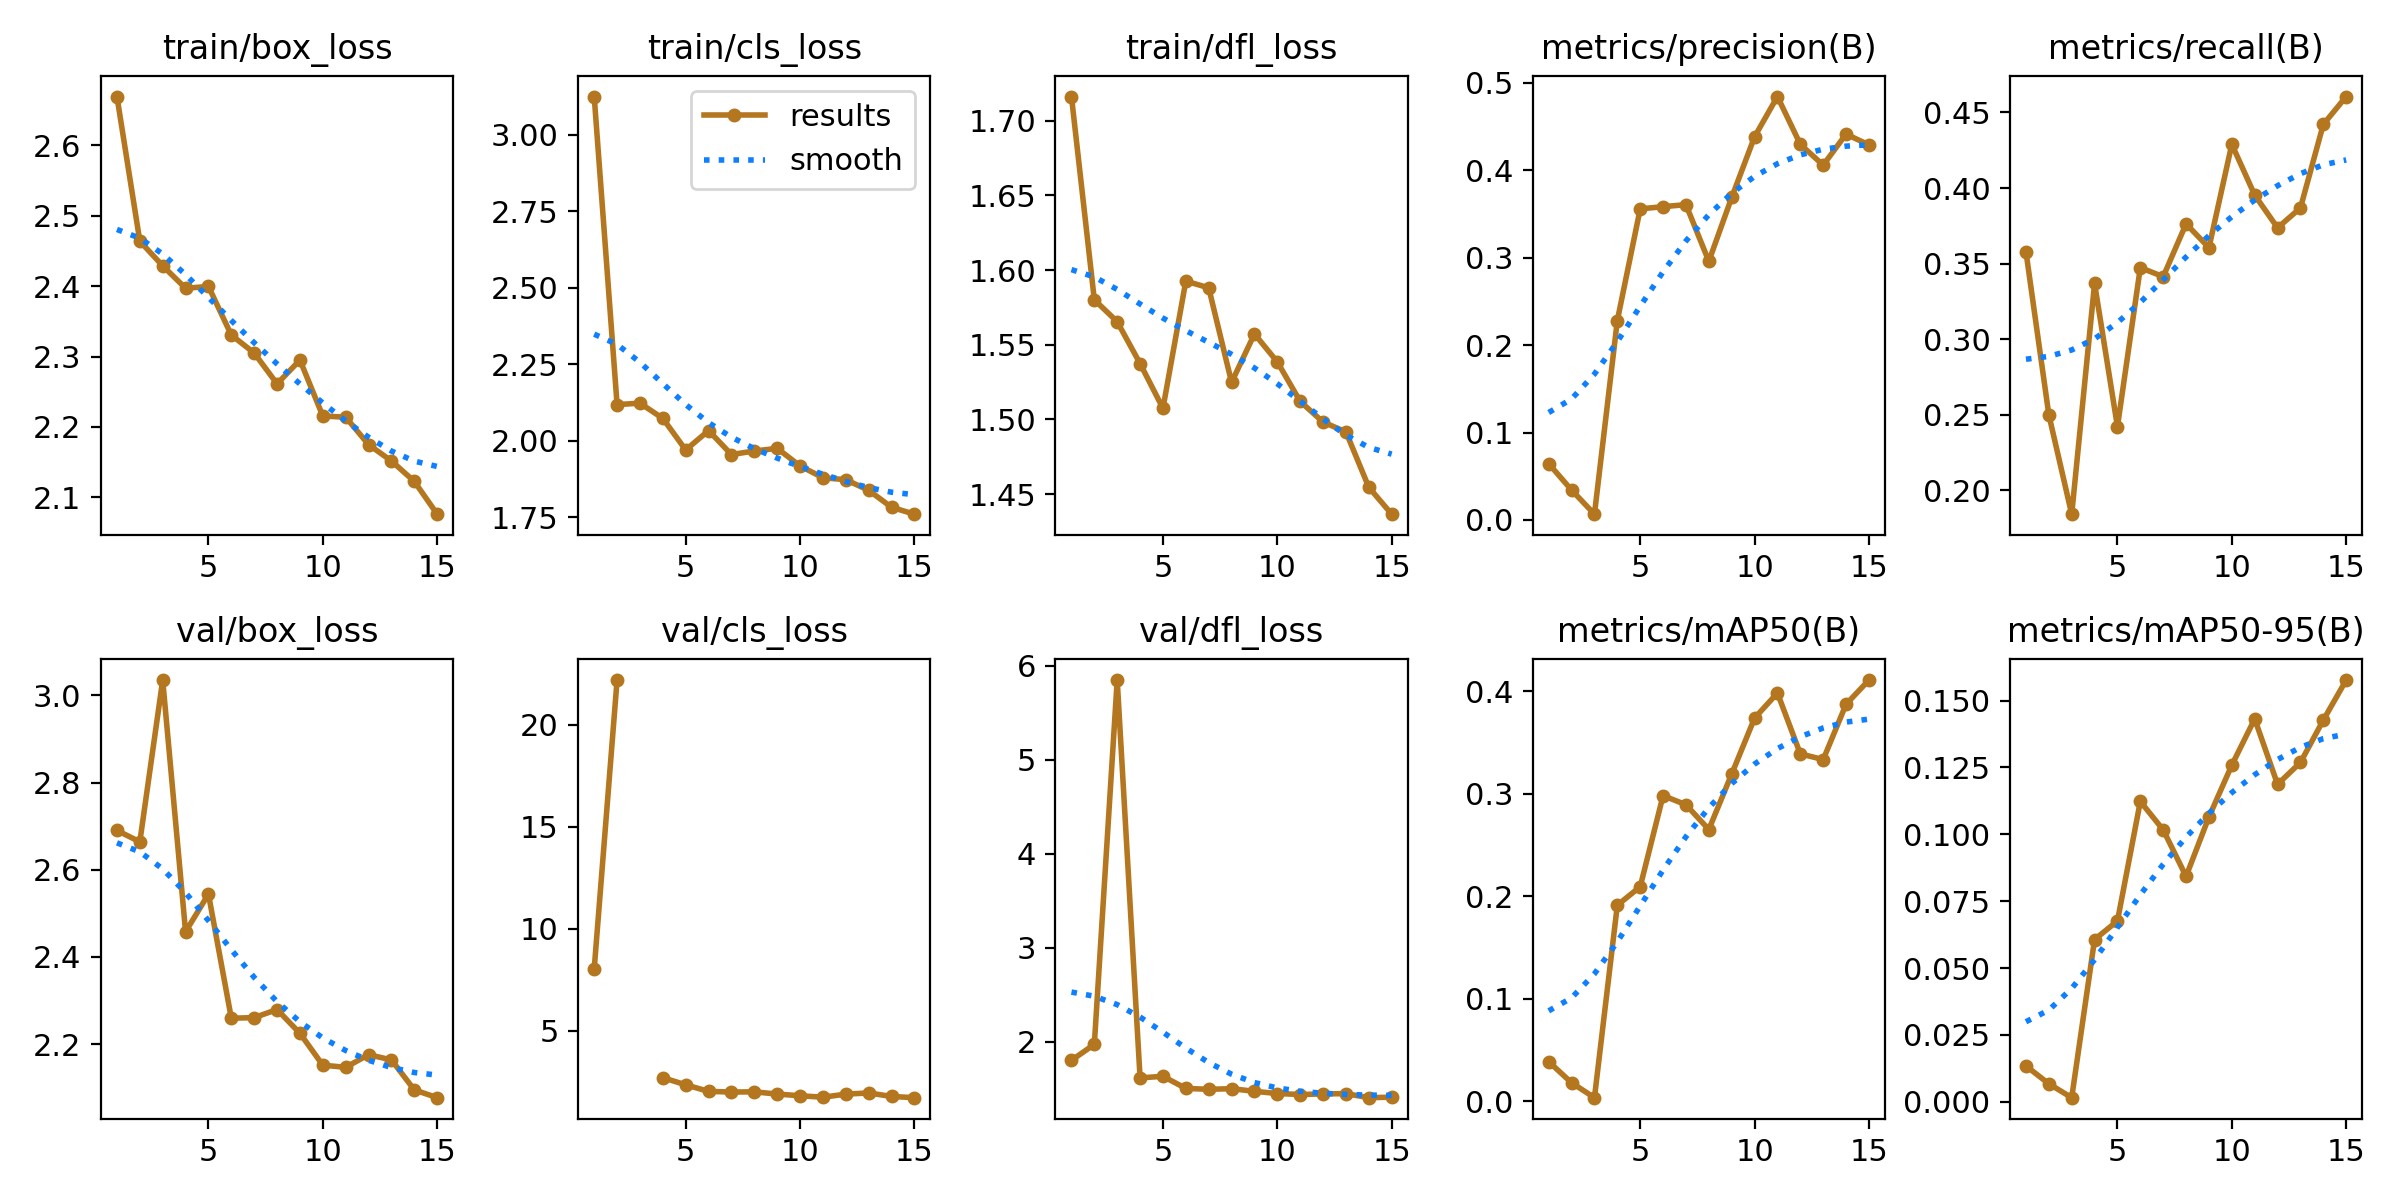

In [ ]:
Image.fromarray(cv2.imread(f"{RES_DIR}/results.png")) # прочитаем и выведем изображение с графиками

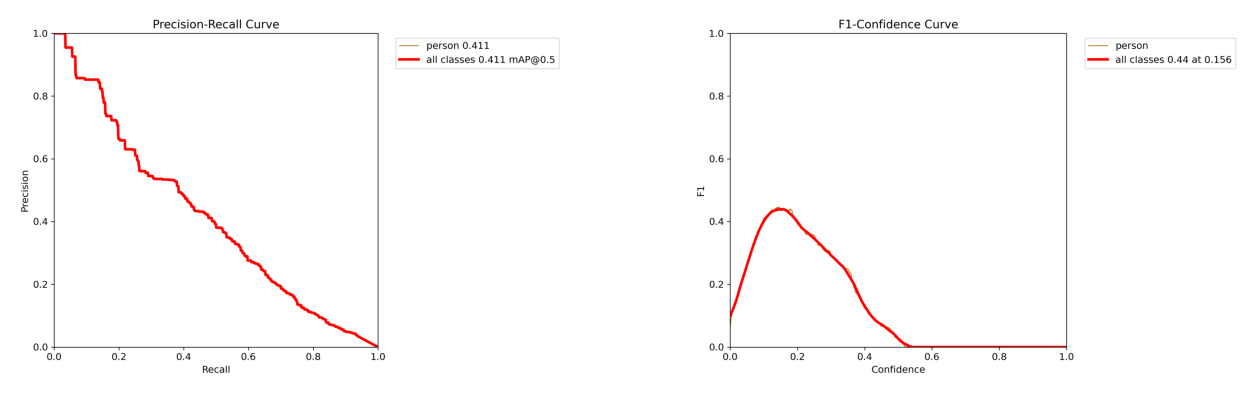

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
axes[0].axis("off")
axes[1].axis("off")
axes[0].imshow(cv2.imread(f"{RES_DIR}/PR_curve.png"))
axes[1].imshow(cv2.imread(f"{RES_DIR}/F1_curve.png"))

Ошибка уменьшается, метрики растут. Всё как надо! Но пока не очень понятно что всё это значит...

## Ошибки и метрики

##### Ошибки:


box_loss - ошибка ограничивающих рамок на базе IoU. IoU отражает степень пересечения между предсказанной и исходной ограничивающей рамкой и считается как отношение пересечения к объединению
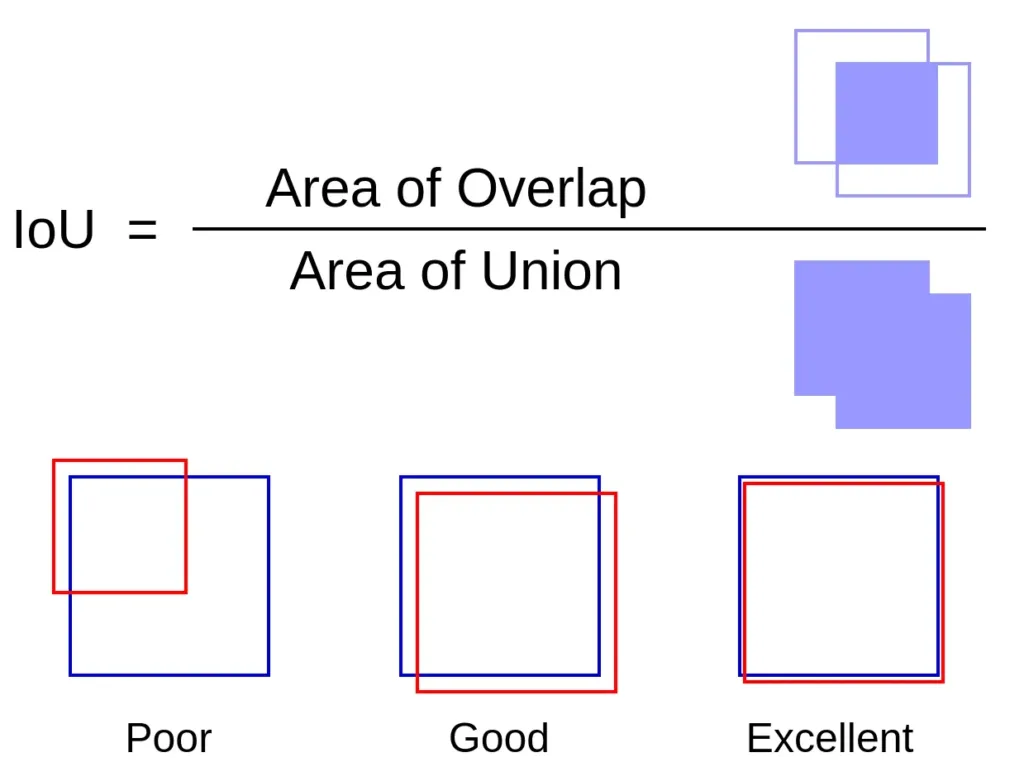

cls_loss - ошибка классификации объекта, используется для определения ошибки в предсказаниях относительно классов объектов.
В модели YOLO, каждый bounding box предсказывает не только координаты прямоугольника (bounding box) объекта, но также вероятности принадлежности к различным классам.

dfl_loss ([distribution focal loss](https://arxiv.org/pdf/2006.04388v1.pdf)) - прокаченная кроссэнтропия, берущая в учёт дисбаланс классов.
Focal Loss уделяет особое внимание "трудным" объектам, у которых низкая вероятность правильного предсказания. Это позволяет модели сосредоточиться на уменьшении ошибок предсказания для таких объектов, что существенно повышает точность обнаружения объектов.

##### Метрики:


Precision и recall метрики основываются на концепции таблицы истинности, в которой все предсказания могут быть отмечены как:
- **True Positive** - классификатор верно отнёс объект к рассматриваемому классу
- **True Negative** - классификатор верно утверждает, что объект не принадлежит к рассматриваемому классу
- **False Positive** - классификатор неверно отнёс объект к рассматриваемому классу
- **False Negative** - классификатор неверно утверждает, что объект не принадлежит к рассматриваемому классу




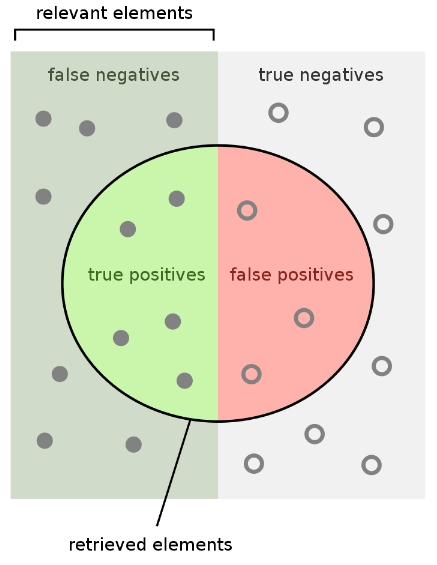

```precision``` (точность) - доля верно обнаруженных объектов из всех предсказаний

$precision = \dfrac{TP}{TP + FP}$



```recall``` (полнота) - доля верно обнаруженных объектов из всех объектов на фото

$recall = \dfrac{TP}{TP + TN}$

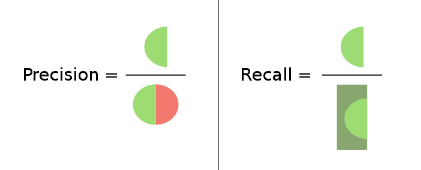

``F-1`` - гармоническое среднее от ``precision`` и ``recall``. Она нужна если нам важна, как точность, так и полнота. Выбранная для метрики формула выдаёт значения ниже, если один из параметров отстаёт от другого. Обычно визуализируется графиком с зависимостью от значений уверенности в предсказании (confidence).

$F1=\dfrac{2*precision*recall}{precision+recall}$

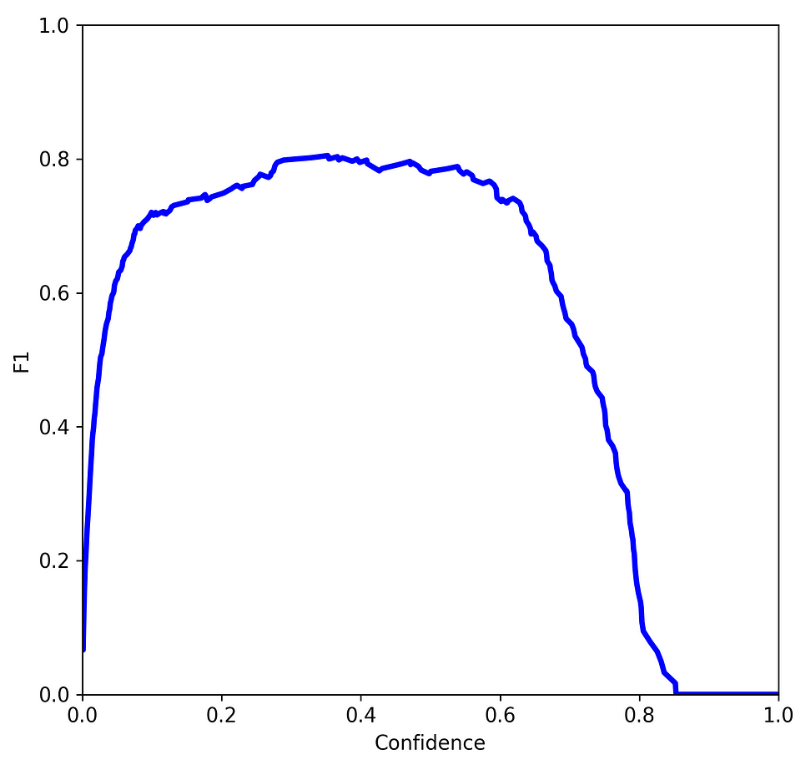

``PR Curve`` - precision-recall кривая. Отражает взаимосвязь между значениями точности и полноты на каждом новом предсказании. На каждом предсказании отмечается точка с координатами x=recall и y=precision.

<div style="display : flex;">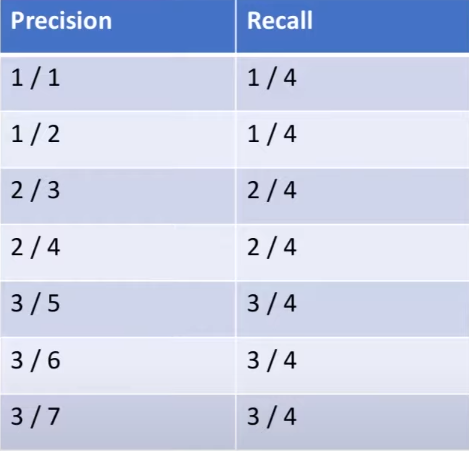
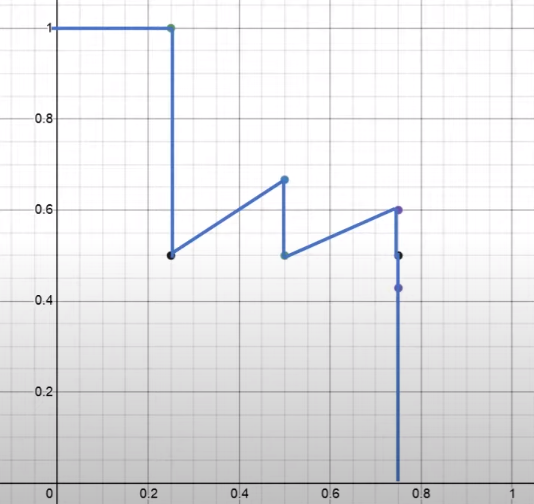
</div>

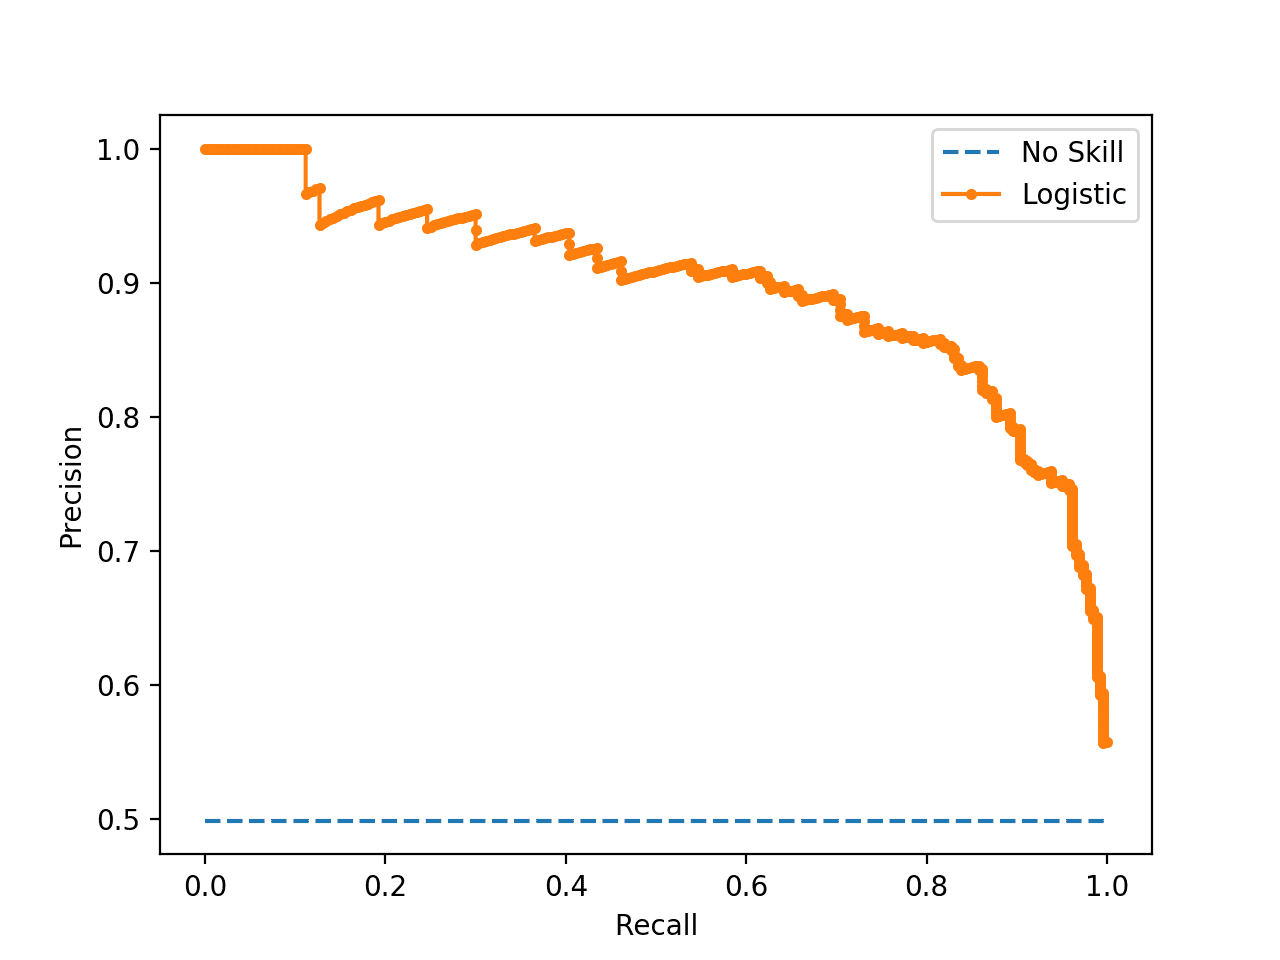

``AP`` (Average Precision) - метрика, рассчитываемая как площадь под PR-кривой конкретного класса.

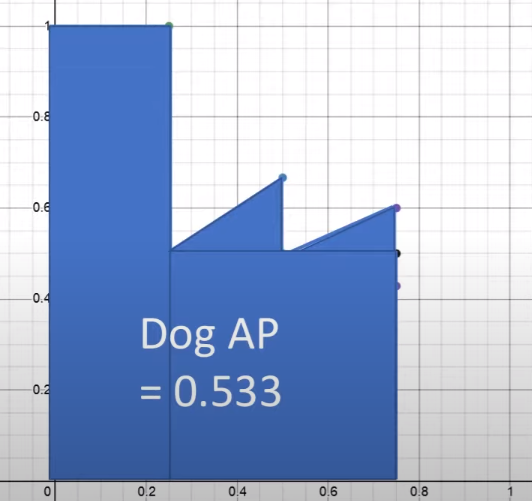

``mAP`` (mean AP) - среднее значение AP по всем классам.

``mAP50`` - среднее значение AP, высчитываемое только для предсказаний с IoU выше 50%

``mAP50-95`` -- `mean(mAP50, mAP55, mAP60, ..., mAP95)`. Первая цифра - нижний порог, вторая - верхний. Шаг по дефолту - 5%.

``mAP@0.5:0.05:0.95`` более явный формат записи со всеми 3 значиениями

## Результат обучения

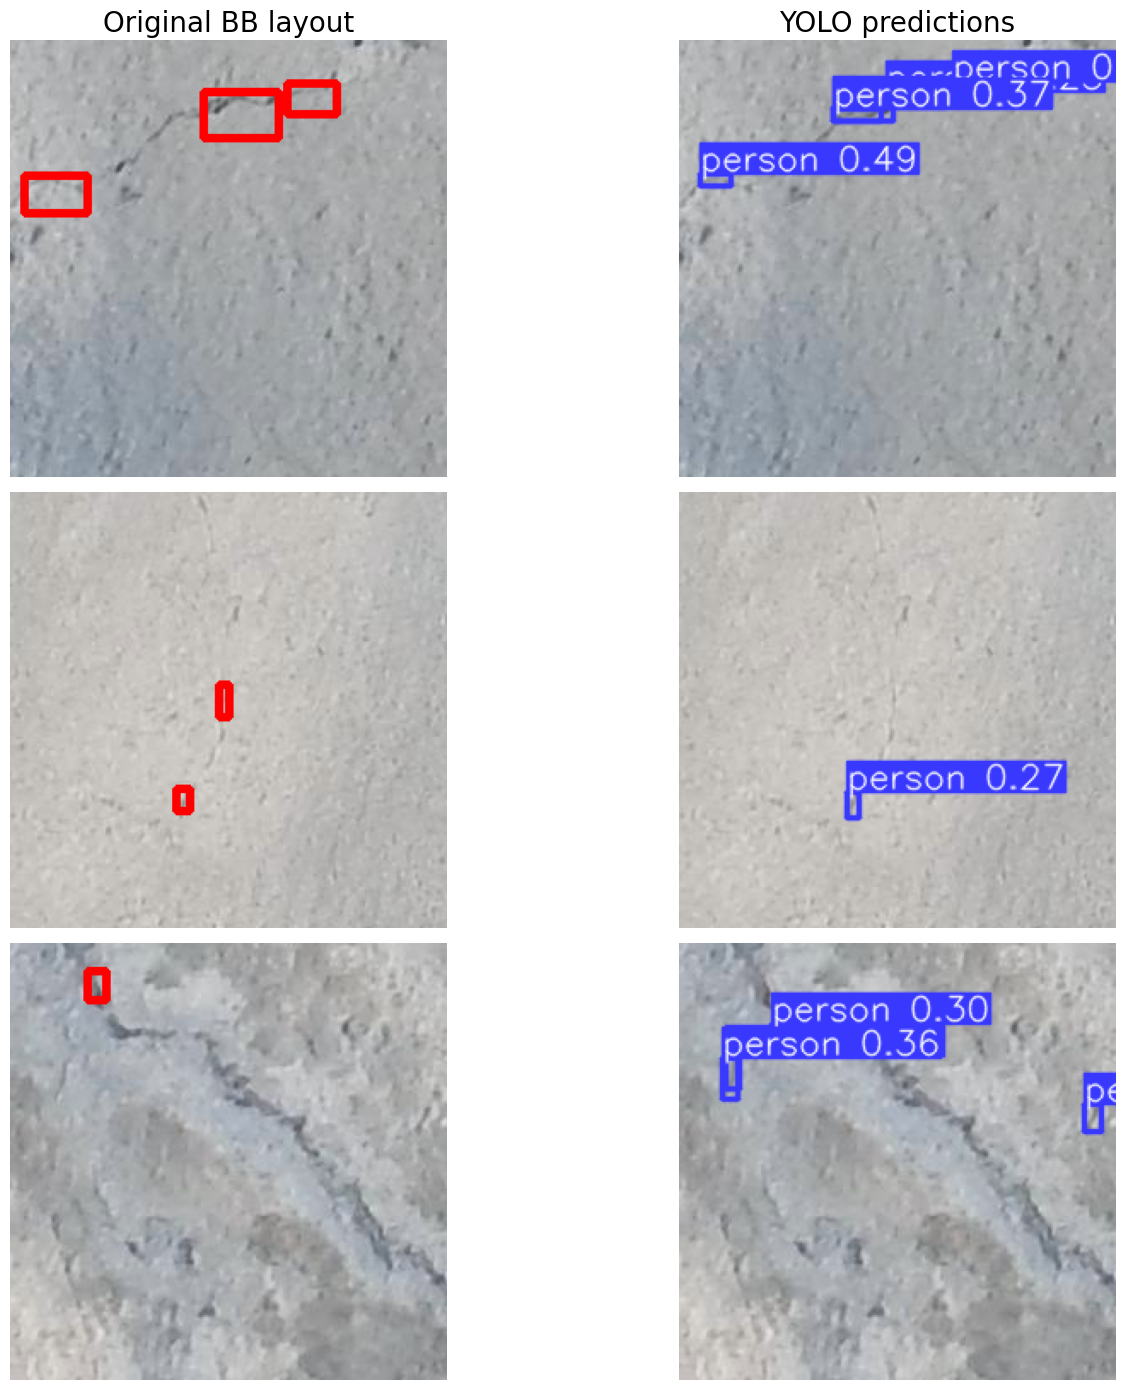

In [ ]:
compare_with_original(results, "test")

## Экспорт

Экспорт модели позволяет переводить её из формата одного фреймворка в другой.

Вот список всех поддерживающихся форматов:


|Format|`format` Argument|Model|Metadata|Arguments|
|---|---|---|---|---|
|[PyTorch](https://pytorch.org/)|-|`yolov8n.pt`|✅|-|
|[TorchScript](https://pytorch.org/docs/stable/jit.html)|`torchscript`|`yolov8n.torchscript`|✅|`imgsz`, `optimize`|
|[ONNX](https://onnx.ai/)|`onnx`|`yolov8n.onnx`|✅|`imgsz`, `half`, `dynamic`, `simplify`, `opset`|
|[OpenVINO](https://docs.ultralytics.com/integrations/openvino/)|`openvino`|`yolov8n_openvino_model/`|✅|`imgsz`, `half`, `int8`|
|[TensorRT](https://developer.nvidia.com/tensorrt)|`engine`|`yolov8n.engine`|✅|`imgsz`, `half`, `dynamic`, `simplify`, `workspace`|
|[CoreML](https://github.com/apple/coremltools)|`coreml`|`yolov8n.mlpackage`|✅|`imgsz`, `half`, `int8`, `nms`|
|[TF SavedModel](https://www.tensorflow.org/guide/saved_model)|`saved_model`|`yolov8n_saved_model/`|✅|`imgsz`, `keras`, `int8`|
|[TF GraphDef](https://www.tensorflow.org/api_docs/python/tf/Graph)|`pb`|`yolov8n.pb`|❌|`imgsz`|
|[TF Lite](https://www.tensorflow.org/lite)|`tflite`|`yolov8n.tflite`|✅|`imgsz`, `half`, `int8`|
|[TF Edge TPU](https://coral.ai/docs/edgetpu/models-intro/)|`edgetpu`|`yolov8n_edgetpu.tflite`|✅|`imgsz`|
|[TF.js](https://www.tensorflow.org/js)|`tfjs`|`yolov8n_web_model/`|✅|`imgsz`, `half`, `int8`|
|[PaddlePaddle](https://github.com/PaddlePaddle)|`paddle`|`yolov8n_paddle_model/`|✅|`imgsz`|
|[ncnn](https://github.com/Tencent/ncnn)|`ncnn`|`yolov8n_ncnn_model/`|✅|`imgsz`, `half`|


Универсальным форматом, который поддерживает конвертацию из любого и в любой фремворк - ONNX.

**ONNX** - Open Neural Network Exchange.

Чтобы выгрузить в него YOLO, достаточно одной строчки:

In [ ]:
model.export(format='onnx')

Ultralytics YOLOv8.0.227 🚀 Python-3.10.12 torch-2.3.0+cu121 CPU (Intel Xeon 2.00GHz)

PyTorch: starting from 'runs/detect/train3/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 5, 8400) (49.6 MB)

ONNX: starting export with onnx 1.16.1 opset 17...
ONNX: export success ✅ 3.8s, saved as 'runs/detect/train3/weights/best.onnx' (98.8 MB)

Export complete (7.9s)
Results saved to /content/runs/detect/train3/weights
Predict:         yolo predict task=detect model=runs/detect/train3/weights/best.onnx imgsz=640  
Validate:        yolo val task=detect model=runs/detect/train3/weights/best.onnx imgsz=640 data=dataset/data/dataset.yaml  
Visualize:       https://netron.app


'runs/detect/train3/weights/best.onnx'

Да, так просто.

Поздравляем! Модель готова в продакшн!